In [327]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [328]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [329]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize the Data

In [330]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2 K-Means (for preprocessing)

### Spherical K-means



1) **Assignment step**: For $i=1,\ldots, n$

$$z^{(i)} \leftarrow \arg\min_{k} \left (1- \frac{\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_k\| \cdot \|\mathbf{x}^{(i)}\|}\right )$$ 

$\qquad$ where $\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} = \sum_{j=1}^d {\mu}_{kj} \cdot {x}^{(i)}_{j}$ denotes the inner product and $\|\mathbf{x}\|$ is $L_2$ norm of a vector $\mathbf{x}$: $\|\mathbf{x}\| = \sqrt{\mathbf{x}^\top \mathbf{x}}$.

2) **Update step**: for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k \leftarrow \frac{\sum_{i=1}^n \mathbb{1}(z^{(i)} =k) \cdot  \mathbf{x}^{(i)}}{\|\sum_{i=1}^n \mathbb{1}(z^{(i)} =k) \cdot \mathbf{x}^{(i)}\|}.$$ 

* After the normalisation step, the centroids $\boldsymbol{\mu}_k$ are norm-one vectors: i.e. $\|\boldsymbol{\mu}_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss converges, where the loss is defined as

$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\boldsymbol{\mu}_{z^{(i)}}^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_{z^{(i)}}\| \cdot \|\mathbf{x}^{(i)}\|}\right ).$$


In [164]:
def cosine_similarity(A, B):
    '''
        Cosine similarity distance function
        @param (A) ; n-dimensional vector (numpy array)
        @param (B) : n-dimensional vector (numpy array)
    '''

    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return dot_product / (norm_A * norm_B)


def assign_step(data, centroids, K, eps=1e-14):
    ''' 
        Assign datapoints to clusters using cosine similarity.
        @param data: data matrix (n x d)
        @param centroids: cluster centroids (K x d)
        @param K: number of clusters
        @return: total similarity (sum of maximum similarities) and one-hot encoded assignments (n x K)
    '''
    # Cosine similarity
    dot_products = np.dot(data, centroids.T)
    
    # Compute the L2 norms for data and centroids
    data_norms = np.linalg.norm(data, axis=1)  # (n,)
    centroids_norms = np.linalg.norm(centroids, axis=1)  # (K,)
    
    # Compute the cosine similarity matrix w/ broadcasting
    cosine_similarities = dot_products / ((data_norms[:, None] * (centroids_norms[None, :])) + eps)
    
    # find the centroid with maximum cosine similarity for each data point
    best_cluster_indices = np.argmax(cosine_similarities, axis=1)
    
    # one-hot encode
    assignments = np.eye(K)[best_cluster_indices]
    
    # Compute the total similarity (sum of max similarities)
    total_similarity = np.sum(np.min(1 - cosine_similarities, axis=1))
    
    return total_similarity, assignments


def update_step(data, zs, eps=1e-14):
    ''' 
        K-mean update step (update cluster assignments of each datapoint)
        @param (data) : the data matrix (n x d)
        @param (zs)   : the datapoint assignments ()
        @param (K)    : the number of clusters
    '''
    _, d = data.shape
    _, k = zs.shape

    sums = zs.T @ data

    norm_sums = np.linalg.norm(sums, axis=1)

    norm_sums = norm_sums.reshape(-1,1) 

    update = np.divide(sums,norm_sums + eps)

    return update


def kmeans(data, K=10, tol= 1e-8, maxIters= 1000):
    ''' 
        K-Means assign-update learning algorithm 
        @param (data) : the data matrix (n x d)
        @param (K) : the number of clusters to assume
        @param (tol) : the convergence check loss amount
        @param (maxIters) : maximum iterations to perform before stopping
    '''
    n, d = data.shape 

    init_us_ids = rng.integers(n, size = K)

    us = data[init_us_ids, :]

    losses = []

    # loop until converge 
    for i in range(maxIters):
        # assignment step
        min_distances, zs = assign_step(data,us,K)
        
        # update step
        us = update_step(data,zs)

        # convergence check  
        losses.append(1 - min_distances)    

        if i > 1 and np.abs(losses[i] - losses[i-1]) < tol : break
    return losses, zs, us

# 3 EM Algorithm

## 3.1 Expectation Step 

Compute responsibility (probability of component generating datapoint) :
$$\begin{align}
\ln r_{ik} &= \ln\pi_k + \ln p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\}) + C\\
&=\ln\pi_k + \sum_{d=1}^D x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd}) + C
\end{align}$$


Log Likelihood:
$$\ell(\boldsymbol{\pi}, \boldsymbol{\mu}s)=\frac{1}{n}\ln p(\{\mathbf{x}^{(i)}\}_{i=1}^n|\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \frac{1}{n} \sum_{i=1}^n\ln\left \{ \sum_{k=1}^K \pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)\right \}$$

In [10]:
def e_step(X, πs, μs, eps=1e-14):
    '''
        πs : k x 1 (priors)
        μs : k x d 
        X  : 500 x d
    '''
    n, D = X.shape
    K = len(πs)
    R = np.zeros((K, n))
    loglik = 0.0

    for k in range(K):
        ll_k = (X @ np.log(μs[k] + eps).T) + ((1 - X) @ np.log(1 - μs[k] + eps).T)

        R[k] = ll_k

    R = np.log(πs + eps) + R.T

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)
    
    # Compute average marginal log likelihood 
    loglik = np.sum(log_R_norm) / n        

    return R, loglik

# 3.2 Maximization Step

For $k=1, \ldots, K$:

$$\pi_k = \frac{n_k}{n};\;\; \boldsymbol{\mu}_k = \frac{\sum_{i=1}^n r_{ik} \cdot \mathbf{x}^{(i)}}{n_k},$$


* where $n_k = \sum_{i=1}^n r_{ik}$

In [11]:
def m_step(X, R):
    ## implement here 
    n, d = X.shape # rows are each datapoint, cols are responsibility to each of K clusters

    nk = np.sum(R, axis=0) 
    πs = nk/n
    μs = (R.T @ X)/nk[:, np.newaxis]

    return πs, μs

## 3.3 EM Algorithm Loop

In [129]:
def em_mixberns(X, K, μs_init=None, tol = 1e-4, maxIters = 100):
	## initilisation
	n, d = X.shape
	
	R = rng.random((n, K))

	# normalize initialization responsibility matrix 
	R /= np.sum(R, axis=1, keepdims=True)

	# perform maximization step
	πs, μs = m_step(X,R)

	if μs_init is not None:
		μs = μs_init

	logLiks = [0.0]

	for i in range(maxIters):
		# E step 
		R, loglik = e_step(X, πs, μs)
		logLiks.append(loglik)

		# M step 
		πs, μs = m_step(X, R)
		zs = np.argmax(R, axis=1)

		# Check for convergence 
		if np.abs(logLiks[-1] - logLiks[-2]) < tol:
			break 
	
	return logLiks, πs, μs, zs, R



In [13]:
def predict(X, πs, μs, eps=1e-14):
    n, D = X.shape
    K = len(πs)
    R = np.zeros((K, n))
    loglik = 0.0

    for k in range(K):
        ll_k = (X @ np.log(μs[k] + eps).T) + ((1 - X) @ np.log(1 - μs[k] + eps).T)
        # full_ll_k = np.log(πs + eps) + ll_k

        R[k] = ll_k

    R = np.log(πs + eps) + R.T

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)

    y_preds = np.argmax(R, axis=1)

    return y_preds

# 3.4 Evaluation

Classify the binary MNIST set

In [130]:
# assume 10 components for digits 0-9
logLiks_em, πs_em, μs_em, zs_em, R_em = em_mixberns(X_mnist_train, 10)

Adjusted rand index:  0.36770923995874816


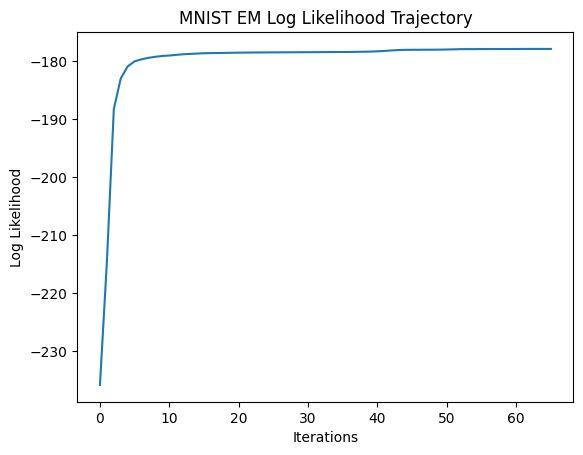

In [131]:
ridx = metrics.adjusted_rand_score(Y_mnist_train, zs_em)

print("Adjusted rand index: ", ridx)

plt.plot(logLiks_em[1:])
plt.title('MNIST EM Log Likelihood Trajectory')
plt.ylabel('Log Likelihood')
plt.xlabel('Iterations')
plt.show()

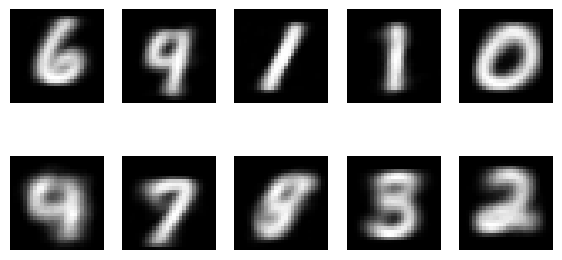

In [65]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = μs_em[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# 4 Gibbs Sampling Algorithm

Joint Posterior 

$$\begin{align}
    p(\mathbf{\pi},\mathbf{\theta},\mathbf{z}|\mathbf{X},\mathbf{\alpha},a,b) \propto p(\mathbf{X}|\mathbf{z},\mathbf{\theta}) p(\mathbf{z}|\mathbf{\pi}) p(\mathbf{\pi}|\mathbf{\alpha}) p(\mathbf{\theta}|a,b)
\end{align}$$

Routine

1) Initialize 
$$\begin{align}
    \boldsymbol{\alpha} &= [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]\\
    a,b &= \frac{1}{2}\\
    \boldsymbol{\pi} &\sim \mathcal{Dirichlet}(\boldsymbol{\alpha})\\
    \boldsymbol{\theta} &\sim \mathcal{Beta}(a,b)\\
    \boldsymbol{z} &\sim \mathcal{Cat}(\boldsymbol{\pi})
\end{align}$$


2) For $t=1,..,N$
$$\begin{align}

\end{align}$$

Softmax:

$$
    \mathbf{softmax}_i(p_k) = \frac{\exp(p_{ik}) - \exp(\mathbf{max}(\mathbf{p}_i))}{\sum_{k'}\exp(p_{ik'})}
$$

In [331]:
def sampleZs(X, θ, π, eps):
    ''' 
        Compute softmax to produce cat distribution for each row

        @param (X) : data matrix (n x d)
        @param (θ) : biases for each pixel (K x d)
        @param (π) : mixture weights for each component (K)
    '''

    # Compute Categorical Distribution over components for each row using SoftMax
    logp  = np.log(π + eps) + (X @ np.log(θ + eps).T + (1 - X) @ np.log(1 - θ + eps).T) # log likelihood
    logp -= logp.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(logp)
    p    /= p.sum(axis=1, keepdims=True) # normalize

    # Inverse Sample from Categorical Distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [332]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    nkd1 = np.zeros((K,d))
    nkd0 = np.zeros((K,d))

    for k in range(K):
        indices = np.where(zs == k)[0].tolist()
        nkd1[k] = X[indices].sum(axis=0)
        nkd0[k] = len(indices) - nkd1[k]
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [333]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs, minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [ ]:
def gibbs(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = sampleZs(X, θs[0], πs[0], eps)

    for t in range(1,num_iter+num_burn):
        πs[t] = sample_π(zs[t-1], α_0, 10)

        θs[t] = sample_θ(X, zs[t-1], a_mat, b_mat, 10)
        
        zs[t] = sampleZs(X, θs[t],πs[t],eps).astype(np.int16)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:]

In [335]:
πs,θs,zs= gibbs(X_mnist_train, 1000, 100, 10)

In [336]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3939520920320415

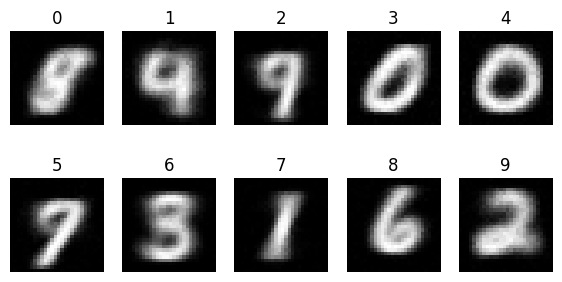

In [338]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = θs[-1][k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()